Set Up for the Agentic Rag

In [1]:
pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importamos librerías necesarias
import os
from dotenv import load_dotenv

# Cargamos variables de entorno
dotenv_path = load_dotenv()

# Leemos las claves
token_openai = os.getenv("OPENAI_API_KEY")
token_tavily = os.getenv("TAVILY_API_KEY")

# Verificar que las claves existen
if not token_openai:
    raise ValueError("❌ Falta la clave OPENAI_API_KEY en el archivo .env")
if not token_tavily:
    raise ValueError("❌ Falta la clave TAVILY_API_KEY en el archivo .env")

print("✅ Claves cargadas correctamente")

✅ Claves cargadas correctamente


## 1 Preprocess the Documents

### 1. Scrap Xakata Web Site

In [3]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from langchain_core.documents import Document
from time import sleep

from typing import List, Set

import requests
from bs4 import BeautifulSoup

# --------------------------------------
# 1. Leer el sitemap_index.xml
# --------------------------------------

def get_category_sitemaps(index_url="https://www.xataka.com/sitemap_index.xml"):
    headers = {"User-Agent": "XaviBot/1.0"}
    response = requests.get(index_url, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    sitemaps = [loc.get_text() for loc in soup.find_all("loc")]
    return sitemaps

category_sitemaps = get_category_sitemaps()
print(f"Se han encontrado {len(category_sitemaps)} sitemaps.")
print("Ejemplo:", category_sitemaps[:3])

# --------------------------------------
# 2. Filtrar solo las categorías importantes
# --------------------------------------

important_categories = [
    "moviles", "portatiles", "ordenadores", "componentes",
    "perifericos", "televisores", "software", "internet",
    "inteligencia-artificial", "videojuegos", "gadgets"
]

filtered_sitemaps = [
    url for url in category_sitemaps
    if any(f"/{cat}/" in url for cat in important_categories)
]

print(f"\nSe han filtrado {len(filtered_sitemaps)} sitemaps relevantes.")
print("Ejemplo:", filtered_sitemaps[:3])

# --------------------------------------
# 3. Extraer URLs de artículos desde los sitemaps
# --------------------------------------

def get_articles_from_category_sitemap(sitemap_url, max_articles=10):
    headers = {"User-Agent": "XaviBot/1.0"}
    response = requests.get(sitemap_url, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    urls = [loc.get_text() for loc in soup.find_all("loc")]
    return urls[:max_articles]

all_articles = []
seen_urls = set()

for sitemap_url in filtered_sitemaps:
    print(f"Procesando {sitemap_url}")
    articles = get_articles_from_category_sitemap(sitemap_url, max_articles=10)

    for url in articles:
        if url not in seen_urls:
            category = url.split("/")[3] if len(url.split("/")) > 3 else "desconocida"
            all_articles.append({
                "url": url,
                "category": category
            })
            seen_urls.add(url)
    sleep(0.5)  # ser amable con el servidor

print(f"\nTotal artículos únicos extraídos: {len(all_articles)}")
for a in all_articles[:3]:
    print(a)

# --------------------------------------
# 4. Scraping del contenido: title + text
# --------------------------------------

def scrape_article(url, category):
    headers = {"User-Agent": "XaviBot/1.0"}
    try:
        
        response = requests.get(url, headers=headers, timeout=10)
        response.encoding = 'utf-8' # <-- aquí el fix

        if response.status_code != 200:
            return None

        soup = BeautifulSoup(response.text, "html.parser")

        title_tag = soup.find("h1")
        paragraphs = soup.find_all("p")

        if not title_tag or not paragraphs:
            return None

        title = title_tag.get_text(strip=True)
        content = "\n\n".join([p.get_text(strip=True) for p in paragraphs])

        return {
            "url": url,
            "title": title,
            "content": content,
            "category": category
        }
    except Exception as e:
        print(f"❌ Error en {url}: {e}")
        return None

# Ejecutar scraping de todos los artículos
scraped_articles = []

for article in all_articles:
    result = scrape_article(article["url"], article["category"])
    if result:
        scraped_articles.append(result)

print(f"\nTotal artículos correctamente scrapeados: {len(scraped_articles)}")
for a in scraped_articles[:10]:
    print(f"- {a['title']} ({a['category']})")




Se han encontrado 333 sitemaps.
Ejemplo: ['https://www.xataka.com/categoria/default/sitemap.xml', 'https://www.xataka.com/categoria/otros/sitemap.xml', 'https://www.xataka.com/categoria/moviles/sitemap.xml']

Se han filtrado 7 sitemaps relevantes.
Ejemplo: ['https://www.xataka.com/categoria/moviles/sitemap.xml', 'https://www.xataka.com/categoria/ordenadores/sitemap.xml', 'https://www.xataka.com/categoria/videojuegos/sitemap.xml']
Procesando https://www.xataka.com/categoria/moviles/sitemap.xml
Procesando https://www.xataka.com/categoria/ordenadores/sitemap.xml
Procesando https://www.xataka.com/categoria/videojuegos/sitemap.xml
Procesando https://www.xataka.com/categoria/perifericos/sitemap.xml
Procesando https://www.xataka.com/categoria/televisores/sitemap.xml
Procesando https://www.xataka.com/categoria/componentes/sitemap.xml
Procesando https://www.xataka.com/categoria/inteligencia-artificial/sitemap.xml

Total artículos únicos extraídos: 60
{'url': 'https://www.xataka.com/moviles/comp

### 2. Convertimos los documentos extraidos al formato Document que espera el Splitter

In [4]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content=article["content"],
        metadata={
            "title": article["title"],
            "url": article["url"],
            "category": article["category"]
        }
    )
    for article in scraped_articles
]

In [5]:
documents[0]

Document(metadata={'title': 'Comprar tecnología de EEUU siempre nos ha salido más caro en Europa. El Fairphone 6 es una dulce venganza', 'url': 'https://www.xataka.com/moviles/comprar-tecnologia-eeuu-siempre-nos-ha-salido-caro-europa-fairphone-6-dulce-venganza', 'category': 'moviles'}, page_content='Javier Pastor\n\nJavier Pastor\n\nElFairphone 6es el último de los miembros de una familia muy especial. Una que siempre se ha caracterizado por su modularidad y reparabilidad, pero que ahora demás nos deja un detalle singular. Este móvil diseñado en Europa es una dulce venganza para los usuarios del viejo continente. Normalmente estamos acostumbrados a pagar más por nuestros dispositivos de lo que pagan los usuarios en EEUU, pero en este caso pasa justamente lo contrario.\n\nCuánto cuesta un iPhone aquí y allí. Pongamos un ejemplo sencillo de la situación de los precios de dispositivos electrónicos en EEUU y en Europa. Un iPhone 16 Pro de 128 GB cuesta999 dólaresen EEUU. A ese precio hay q

#### 2.1 Chunking

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter 
from typing import List

def split_documents(
    docs: List[Document],
    chunk_size: int = 500,
    chunk_overlap: int = 100
) -> List[Document]:
    """
    Divide documentos largos en fragmentos más pequeños usando RecursiveCharacterTextSplitter.

    Args:
        docs: Lista de Documentos de LangChain.
        chunk_size: Tamaño máximo de cada fragmento.
        chunk_overlap: Número de caracteres que se solapan entre fragmentos.

    Returns:
        Lista de documentos divididos.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunked = text_splitter.split_documents(docs)
    print(f"📄 Documentos originales: {len(docs)} → 🧩 Chunks generados: {len(chunked)}")
    return chunked


In [7]:
doc_splits = split_documents(documents, chunk_size=500, chunk_overlap=200)

print(f"Se han generado {len(doc_splits)} fragmentos.")

📄 Documentos originales: 30 → 🧩 Chunks generados: 203
Se han generado 203 fragmentos.


In [8]:
doc_splits[0].page_content.strip()

'Javier Pastor\n\nJavier Pastor\n\nElFairphone 6es el último de los miembros de una familia muy especial. Una que siempre se ha caracterizado por su modularidad y reparabilidad, pero que ahora demás nos deja un detalle singular. Este móvil diseñado en Europa es una dulce venganza para los usuarios del viejo continente. Normalmente estamos acostumbrados a pagar más por nuestros dispositivos de lo que pagan los usuarios en EEUU, pero en este caso pasa justamente lo contrario.\n\nCuánto cuesta un iPhone aquí y allí. Pongamos un ejemplo sencillo de la situación de los precios de dispositivos electrónicos en EEUU y en Europa. Un iPhone 16 Pro de 128 GB cuesta999 dólaresen EEUU. A ese precio hay que sumarle los impuestos estatales, que varían entre cada estado y que pueden llegar a ser del 10%. Así pues, el precio puede ascender a unos 1.100 dólares, impuestos incluidos. Al cambio actual eso equivaldría a unos 944 euros. El precio de ese mismo dispositivo en nuestro país, impuestos incluidos

In [9]:
doc_splits[1].page_content.strip()

'Un móvil diferente. Y ahora hablemos del Fairphone 6. Estamos ante un smartphone que es muy distinto a sus competidores. No tanto por sus prestaciones —siempre más modestas que sus competidores en el mismo rango de precios— sino por un enfoque que apuesta al máximo por la modularidad y la reparabilidad. En Europa el precio del Fairphone 6 con Android 15 (8/256 GB) estádisponible por 599 euros, impuestos incluidos.\n\nViva el derecho a reparar. Los Fairphone 6 no van a ganar ninguna carrera por la potencia o por las mejores cámaras, pero sí la delderecho a reparar. Basta quitar unos tornillos convencionales —nada de cabezales extraños o propietarios— para acceder al interior y poder extraer hasta 12 partes del terminal, desde la pantalla a la batería pasando por los altavoces o la cámara.\n\nEl Fairphone 6 con e/OS. Y aquí llega lo interesante, porque además de la versión con Android el Fairphone 6 también lo vende la empresa Murena. En este caso lo hacepreinstalando e/OS, una versión 

In [10]:
doc_splits[2].page_content.strip()

'El Fairphone 6 con e/OS. Y aquí llega lo interesante, porque además de la versión con Android el Fairphone 6 también lo vende la empresa Murena. En este caso lo hacepreinstalando e/OS, una versión de Android AOSP que nos "libera" de los servicios y aplicaciones de Google aunque podemos instarlalos posteriormente gracias alsoporte MicroG. En Europa Murena vende su Fairphone 6 con e/OS por 649 euros, y ese es precisamente el modelo que está disponible en EEUU.\n\nEste móvil sale caro en EEUU. Murena también ofrece el Fairphone 6 con e/OS en Estados Unidos, pero en ese caso el precio de es899 dólares. Si aplicamos la misma tasa estatal, que puede llegar al 10%, ese precio se convierte en unos 989 dólares, que al cambio suponen 849 euros. Es decir: en EEUU este móvil cuesta 200 dólares más, un 30,82% más de lo que nos cuesta en Europa.\n\nAranceles. Hay varias razones para esa diferencia entre el precio del Fairphone 6 en Europa y en EEUU, perouna de ellas es la de los aranceles. Este móv

## 2. Creamos el retriever tool en memoria.

### 1. Use an in-memory vector store and OpenAI embeddings

In [11]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
#Lo dejo para demostrar que los embeddings tienen una cierta cantidad de tokens con lo cual es mejor partir
# vectorstore = InMemoryVectorStore.from_documents(
#     documents=doc_splits, embedding=OpenAIEmbeddings()
# )
# retriever = vectorstore.as_retriever()
vectorstore = InMemoryVectorStore(embedding=OpenAIEmbeddings())

In [12]:
# 2. Procesa por batches (lotes). Tenemos que procesar por lotes por que no admite mas de 300000  tokens
batch_size = 500

for i in range(0, len(doc_splits), batch_size):
    batch = doc_splits[i:i + batch_size]
    # Procesa cada batch aquí. Ejemplo: añade al VectorStore
    vectorstore.add_documents(batch)
    print(f"Procesando batch {i//batch_size + 1} con {len(batch)} chunks...")

    # Aquí va tu código de procesamiento, por ejemplo:
    # vectorstore.add_documents(batch)

Procesando batch 1 con 203 chunks...


In [13]:
retriever = vectorstore.as_retriever()

### 2. Creamos una retriever **tool** usando LangChain's prebuilt create_retriever_tool:

In [14]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",#nombre
    "Busca y devuelve info acerca de articulos de Xakata.",#Descripcion
)

In [15]:
# retriever_tool.invoke({"query": "¿Como se actualiza un Google Pixel?"})

# retriever_tool.invoke({"query": "Galaxy Z Flip7 "})
# 
retriever_tool.invoke({"query": "¿Como Samsung a adelanto Google?"})

'Antonio Sabán\n\nAntonio Sabán\n\nSamsung lleva19 años siendo el fabricante más televisores vendeen todo el mundo. En 2006 arrebató el liderato a LG, que años antes había hecho lo propio con Sony. Desde entonces, Corea del Sur ha mandado en este mercado sucediendo a lo que fue Japón en su momento. La situación está cerca de cambiar.\n\nQué está pasando. El mercado de los televisores se está moviendo como nunca. En 2022,TCL superó a LGcomo segundo mayor fabricante del mundo. Hisense logró empatar en cuota de mercado yal año siguiente le superó. Pero LG no es la única surcoreana que está sintiendo el poder de los fabricantes chinos. Según datos de Counterpoint, Samsung contaba hace tres años con un 17% de cuota de mercado en televisores. Cayó al 16% en 2023, yse mantuvo en esos números en 2024. Pero.\n\nTCL y Hisense están dando donde más duele. Samsung ha logrado mantenerse primera, pero los datos hablan muy claro sobre el camino que está siguiendo el mercado. Samsung estácayendo un 3,

### 3. Test the tool

## 3. Generamos la Query.
Ahora comenzaremos a construir los componentes (nodos y aristas) para nuestro grafo agentic RAG. Ten en cuenta que los componentes operarán sobre el MessagesState — el estado del grafo que contiene una clave messages con una lista de mensajes de chat.

### 1.Construir un **nodo genera_query_o_responde**. Este llamará a un LLM para generar una respuesta basada en el estado actual del grafo (lista de mensajes). Dado el conjunto de mensajes de entrada, decidirá si recuperar información usando la herramienta de recuperación (retriever tool), o responder directamente al usuario. Ten en cuenta que le estamos dando acceso al modelo conversacional a la herramienta de recuperación que creamos antes, a través de .bind_tools:

In [16]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI

response_model=  ChatOpenAI(model="gpt-4o", temperature=0)

def genera_query_o_responde(state: MessagesState):
    """Llama al modelo para generar una respuesta basada en el estado actual.
      Dada la pregunta, decidirá si recupera información usando la herramienta de recuperación o simplemente responde al usuario."""
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

### 2. Lo probamos con una pregunta aleatoria que no tenga que ver con la info obtenida

In [17]:
input = {"messages": [{"role": "user", "content": "¿Cuanto vale una cortina?"}]}
respuesta= genera_query_o_responde(input)
print (respuesta)

{'messages': [AIMessage(content='El precio de una cortina puede variar ampliamente dependiendo de varios factores, como el material, el tamaño, el diseño, la marca y el lugar donde se compre. Aquí hay algunos rangos generales de precios:\n\n1. **Cortinas de tela básica**: Pueden costar desde $10 hasta $50 por panel, dependiendo del tamaño y la calidad de la tela.\n\n2. **Cortinas de lujo o de diseñador**: Estas pueden costar desde $100 hasta varios cientos de dólares por panel.\n\n3. **Cortinas opacas o blackout**: Generalmente cuestan más que las cortinas estándar, con precios que oscilan entre $20 y $100 por panel.\n\n4. **Cortinas personalizadas**: Si decides hacer cortinas a medida, el costo puede ser significativamente mayor, dependiendo de las especificaciones.\n\n5. **Cortinas de materiales especiales**: Como las cortinas térmicas o acústicas, pueden tener un precio más alto debido a sus propiedades adicionales.\n\nPara obtener un precio exacto, te recomendaría visitar tiendas e

In [18]:
#cogemos el ultimo mensaje
respuesta["messages"][-1]

AIMessage(content='El precio de una cortina puede variar ampliamente dependiendo de varios factores, como el material, el tamaño, el diseño, la marca y el lugar donde se compre. Aquí hay algunos rangos generales de precios:\n\n1. **Cortinas de tela básica**: Pueden costar desde $10 hasta $50 por panel, dependiendo del tamaño y la calidad de la tela.\n\n2. **Cortinas de lujo o de diseñador**: Estas pueden costar desde $100 hasta varios cientos de dólares por panel.\n\n3. **Cortinas opacas o blackout**: Generalmente cuestan más que las cortinas estándar, con precios que oscilan entre $20 y $100 por panel.\n\n4. **Cortinas personalizadas**: Si decides hacer cortinas a medida, el costo puede ser significativamente mayor, dependiendo de las especificaciones.\n\n5. **Cortinas de materiales especiales**: Como las cortinas térmicas o acústicas, pueden tener un precio más alto debido a sus propiedades adicionales.\n\nPara obtener un precio exacto, te recomendaría visitar tiendas en línea o físi

In [19]:
#Formateamos el mensaje
respuesta["messages"][-1].pretty_print()

================================== Ai Message ==================================

El precio de una cortina puede variar ampliamente dependiendo de varios factores, como el material, el tamaño, el diseño, la marca y el lugar donde se compre. Aquí hay algunos rangos generales de precios:

1. **Cortinas de tela básica**: Pueden costar desde $10 hasta $50 por panel, dependiendo del tamaño y la calidad de la tela.

2. **Cortinas de lujo o de diseñador**: Estas pueden costar desde $100 hasta varios cientos de dólares por panel.

3. **Cortinas opacas o blackout**: Generalmente cuestan más que las cortinas estándar, con precios que oscilan entre $20 y $100 por panel.

4. **Cortinas personalizadas**: Si decides hacer cortinas a medida, el costo puede ser significativamente mayor, dependiendo de las especificaciones.

5. **Cortinas de materiales especiales**: Como las cortinas térmicas o acústicas, pueden tener un precio más alto debido a sus propiedades adicionales.

Para obtener un precio exac

### 3. Hacer una pregunta que requiera búsqueda semántica

In [20]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "¿Cómo adelantó Samsumng a Google",
        }
    ]
}
genera_query_o_responde(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_80sNgghWPwIWYHr19e6PbR7T)
 Call ID: call_80sNgghWPwIWYHr19e6PbR7T
  Args:
    query: Samsung adelanta a Google


## 4. Vemos la relevanciade los documentos

###  1.  Añade una arista condicional —grade_documents— para determinar si los documentos recuperados son relevantes para la pregunta. <span style="color:red">Utilizaremos un modelo con un esquema de salida estructurado llamado GradeDocuments</span> para la calificación de documentos. La función grade_documents devolverá el nombre del nodo al que se debe ir según la decisión de calificación (genera respuesta o reescribe_pregunta):

Conceptos a recordar: 
* <span style="color:red">arista condicional</span>

In [21]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "Eres un evaluador que determina la relevancia de un documento recuperado respecto a una pregunta del usuario. \n "
    "Aquí tienes el documento recuperado: \n\n {context} \n\n"
    "Aquí tienes la pregunta del usuario: {question} \n"
    "Si el documento contiene palabra(s) clave o significado semántico relacionado con la pregunta del usuario, califícalo como relevante. \n"
    "Da una puntuación binaria 'si' o 'no' para indicar si el documento es relevante para la pregunta."

)


class GradeDocuments(BaseModel):
    """Califica los documentos utilizando una puntuación binaria para comprobar su relevancia"""

    binary_score: str = Field(
        description="Puntuación : 'si' si es relevante, o 'no' si no lo es"
    )


grader_model = init_chat_model("openai:gpt-4.1", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["genera_respuesta", "rescribir_question"]:
    """Determina si los documentos recuperados son relevantes para la pregunta."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    print ("question:",question)
    print("context: ", context)
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print ("score :", score)
    if score == "si":
        return "genera_respuesta"
    else:
        return "rescribir_question"

### 2. Ejecutar con una respuesta irrelevante en la respuesta de la tool :

In [22]:
#simulamos la respuesta de la tool mediante mensajes
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Que tiempo hace en Alcante?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "Tiempo en Alicante"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}

print ("input:" , input)
grade_documents(input)

input: {'messages': [HumanMessage(content='¿Que tiempo hace en Alcante?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Tiempo en Alicante'}, 'id': '1', 'type': 'tool_call'}]), ToolMessage(content='Son las 10 de la mañana', tool_call_id='1')]}
question: ¿Que tiempo hace en Alcante?
context:  Son las 10 de la mañana
score : no


'rescribir_question'

### 3. Confirmar que el documento/respuesta relavante se  clasifica como tal:

In [23]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Cómo Samsung a adelanto Google?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Cómo Samsung a adelanto Google?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Samsung fue la primera en lograr algo insólito: adelantar a Google en política de actualizaciones. El fabricante ofrecesiete años de actualizaciones de sistemay otros siete años de parches de seguridad.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

question: ¿Cómo Samsung a adelanto Google?
context:  Samsung fue la primera en lograr algo insólito: adelantar a Google en política de actualizaciones. El fabricante ofrecesiete años de actualizaciones de sistemay otros siete años de parches de seguridad.
score : si


'genera_respuesta'

## 5 Rescribir la pregunta.

### 1. Construye el nodo de reescritura de pregunta (rescribir_question).
La herramienta de recuperación puede devolver documentos potencialmente irrelevantes, lo que indica la necesidad de mejorar la pregunta original del usuario. Para ello, llamaremos al nodo rewrite_question.

In [24]:
REWRITE_PROMPT = (
    "Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.\n"
    "Pregunta original:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:"
)


def rescribir_question(state: MessagesState):
    """Rescribe/Mejora la pregunta original del usuario."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    print ("xavi Prompt",prompt)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

#### 2. Try it out:

In [25]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Cómo Samsung a adelanto Google?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Cómo Samsung a adelanto Google?"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}

response = rescribir_question(input)
print(response["messages"][-1]["content"])

xavi Prompt Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.
Pregunta original:
 ------- 
¿Cómo Samsung a adelanto Google?
 ------- 
Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:
¿Cómo ha logrado Samsung superar a Google?


## 6. Generamos la Respuesta.

### 1. Construimos el nodo generate_answer.
Si superamos las comprobaciones del evaluador (grader), podemos generar la respuesta final basándonos en la pregunta original y el contexto recuperado

In [26]:
GENERATE_PROMPT = (
    "Eres un asistente para tareas de preguntas y respuestas. "
    "Utiliza los siguientes fragmentos de contexto recuperado para responder a la pregunta. "
    "Si no sabes la respuesta, simplemente indica que no la sabes. "
    "Utiliza un máximo de tres frases y mantén la respuesta concisa.\n"
    "Pregunta: {question} \n"
    "Contexto: {context}"
)



def genera_respuesta(state: MessagesState):
    """Genera la respuesta."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

### 2. Try it out.

In [27]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Cómo ha logrado Samsung superar a Google?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Cómo ha logrado Samsung superar a Google?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Samsung fue la primera en lograr algo insólito: adelantar a Google en política de actualizaciones. El fabricante ofrecesiete años de actualizaciones de sistemay otros siete años de parches de seguridad.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = genera_respuesta(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Samsung ha logrado superar a Google en política de actualizaciones al ofrecer siete años de actualizaciones de sistema y otros siete años de parches de seguridad, lo cual es más extenso que lo que ofrece Google.


## 7. Configurar el grafo

### 7.1 Importamos los elementos necesarios para construir el grafo

In [28]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### 7.2 Ensamblamos el workflow

#### 7.2.1 Añadimos los nodos

In [29]:
workflow = StateGraph(MessagesState)
workflow.add_node(genera_query_o_responde)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rescribir_question)
workflow.add_node(genera_respuesta)

#### 7.2.2 Añadimos las aristas

In [30]:
workflow.add_edge(START, "genera_query_o_responde")
workflow.add_conditional_edges(
    "genera_query_o_responde",
    # Evalúa la decisión del LLM (llama a la herramienta retriever_tool o responde al usuario)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

#
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)

workflow.add_edge("genera_respuesta", END)

workflow.add_edge("rescribir_question", "genera_query_o_responde")

#### 7.2.3 Compilamos el grafo

In [31]:
graph = workflow.compile()

#### 7.2.4 Pintamos el Grafo

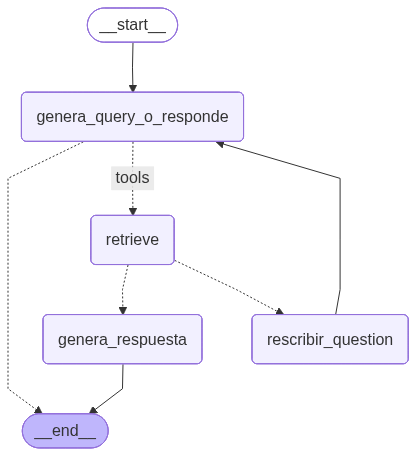

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


### NOtas

In [33]:
from pprint import pprint  # para imprimir bonito

# for chunk in graph.stream(
#     {
#         "messages": [
#             {
#                 "role": "user",
#                 "content": "¿Cómo ha logrado Samsung superar a Google?",
#             }
#         ]
#     }
# ):
#     for node, update in chunk.items():
#         print(f"🔁 Update from node: {node}")
#         print(update["messages"][-1])
#         print("📝 Mensaje generado:")
#         print(messages[-1])
#         print("\n\n")

import pdb
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "¿Cómo ha logrado Samsung superar a Google?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print(f"📘 Update from node: {node}")
        print("-" * 40)

        messages = update.get("messages", [])
      
        last_msg = messages[-1]

        try:
            if isinstance(last_msg, dict):
                if "content" in last_msg:
                    print("📝 Contenido textual:")
                    print(last_msg["content"])
                elif "tool_calls" in last_msg:
                    print("🔧 Llamada a función:")
                    pprint(last_msg["tool_calls"])
                else:
                    print("🕵️ Mensaje dict sin content/tool_calls:")
                    pprint(last_msg)
            elif hasattr(last_msg, "content"):
                print("📝 Contenido desde objeto:")
                print(last_msg.content)
            else:
                print("🕵️ Mensaje desconocido:")
                pprint(last_msg)

        except Exception as e:
            print("❌ Error leyendo el mensaje:", str(e))
            pprint(last_msg)

        print("-" * 40 + "\n")



📘 Update from node: genera_query_o_responde
----------------------------------------
📝 Contenido desde objeto:

----------------------------------------

question: ¿Cómo ha logrado Samsung superar a Google?
context:  Antonio Sabán

Antonio Sabán

Samsung lleva19 años siendo el fabricante más televisores vendeen todo el mundo. En 2006 arrebató el liderato a LG, que años antes había hecho lo propio con Sony. Desde entonces, Corea del Sur ha mandado en este mercado sucediendo a lo que fue Japón en su momento. La situación está cerca de cambiar.

Qué está pasando. El mercado de los televisores se está moviendo como nunca. En 2022,TCL superó a LGcomo segundo mayor fabricante del mundo. Hisense logró empatar en cuota de mercado yal año siguiente le superó. Pero LG no es la única surcoreana que está sintiendo el poder de los fabricantes chinos. Según datos de Counterpoint, Samsung contaba hace tres años con un 17% de cuota de mercado en televisores. Cayó al 16% en 2023, yse mantuvo en esos nú

In [34]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "¿Cómo ha logrado Samsung adelantar a Google?",
        }
    ]
}

In [35]:
graph.invoke(input)

question: ¿Cómo ha logrado Samsung adelantar a Google?
context:  Un mercado que se han quedado TCL y BOE. Y que en su parte más rentable va a darles alegrías, pues las estimaciones apuntan a que este año, lasminiLED superarán en ventasa las OLED de Samsung y LG. Y pese a que LG y Samsung comercializan miniLED, lo hacen con paneles procedentes de fabricantes chinos por la venta de sus fábricas.

La inesperada ayuda de Estados Unidos. Gobierno de Corea del Sur estáapoyando con subvenciones a Samsung y LG, y las noticias que llegan desde Estados Unidos les favorecen: hay congresistas estadounidensespidiendo incluir a BOE en la "lista negra". Si la petición prospera, perder la venta de paneles a Apple y la posibilidad de entrar en el enorme mercado estadounidense de televisores puede dejar a la compañía muy tocada.

Destacada | Samsung,Arthur WangenUnsplash

En Xataka |Si la pregunta es hasta cuándo crecerán las teles de nuestro salón, el mercado habla muy claro: hasta que no nos quepan

L

{'messages': [HumanMessage(content='¿Cómo ha logrado Samsung adelantar a Google?', additional_kwargs={}, response_metadata={}, id='904cf5c0-04b9-494a-b0c5-0c9fd72f0487'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FnuENnFP4jIYuz5MHKawDKXY', 'function': {'arguments': '{"query":"Samsung adelanta a Google"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 68, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C9DEzpGyLXmuyCXYk3emLfLhthPOC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d65b6e56-be02-46c8-af71-ecb87f4ac03d-0', tool_calls=[{'name': 'retrieve_blog_

Notas para la reu: Definición rápida:
Un agente en LangChain es una entidad capaz de razonar paso a paso, decidir qué herramientas o funciones usar, ejecutar acciones (como buscar información, hacer cálculos, llamar APIs, etc.), y combinar resultados para dar una respuesta final.

¿En qué se diferencia de una simple cadena ("chain")?
Chain: Es una secuencia fija de pasos (ej: extrae datos → llama a un LLM → genera texto).

Agente: Toma decisiones sobre qué hacer en cada paso, según el contexto y los resultados anteriores. Puede elegir diferentes herramientas, iterar, preguntar, buscar, etc. No sigue una ruta fija.

¿Cómo funciona un agente en LangChain?
Recibe una pregunta o tarea.

El LLM interpreta la tarea y decide cuál (o cuáles) herramientas necesita para resolverla (por ejemplo: buscar en Google, consultar una base de datos, hacer cálculos, etc.).

Ejecuta acciones: llama a la(s) herramienta(s), analiza los resultados, decide si necesita más pasos.

Itera hasta tener suficiente información.

Redacta la respuesta final al usuario.

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/

